<p style="font-size: 22pt; color: green; font-family: 'Times New Roman';">
 notebook to plot Conditional Probability figure <br>
 <span style="font-size: 12pt; color: black;"> by Praveen Kumar and Bob Kopp </span>
</p>

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cond_dist as cd

<hr style="border: none; height: 2px; background-color: blue; border-style: dotted;">
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Read Data:: <span style="font-size: 13pt; color: black;"> FACTS 1.1.1</span>
</span>


In [2]:
path = os.path.expanduser(f'~/werk.M2/0000_facts-OPdata.M2/amarel/ar2208/factsv1.1.1/coupling.ssp245/output/')

# !-----------------------------------------------------------------!
Yr1=2030 # Xaxis (Vary ; 2030component)
dat1a='coupling.ssp245.total.workflow.wf2f.local.nc'
dat1b='coupling.ssp245.total.workflow.wf2f.global.nc'
dat1c='coupling.ssp245.ocean.tlm.sterodynamics_globalsl.nc'
dat1d='coupling.ssp245.ocean.tlm.sterodynamics_localsl.nc'
dat1e='coupling.ssp245.larmip.larmip.AIS_globalsl.nc'

# !---!
Yr2=2100 # Yaxis (fixed ; NYC RSL 2100)
dat2='coupling.ssp245.total.workflow.wf2f.local.nc' 

# !-----------------------------------------------------------------!
INdata1a, datNMEa  = cd.prepData(path, dat1a, dat2, Yr1, Yr2)
INdata1b, datNMEb  = cd.prepData(path, dat1b, dat2, Yr1, Yr2)
INdata1c, datNMEc  = cd.prepData(path, dat1c, dat2, Yr1, Yr2)
INdata1d, datNMEd  = cd.prepData(path, dat1d, dat2, Yr1, Yr2)
INdata1e, datNMEe  = cd.prepData(path, dat1e, dat2, Yr1, Yr2)

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: raw data / samples
</span>


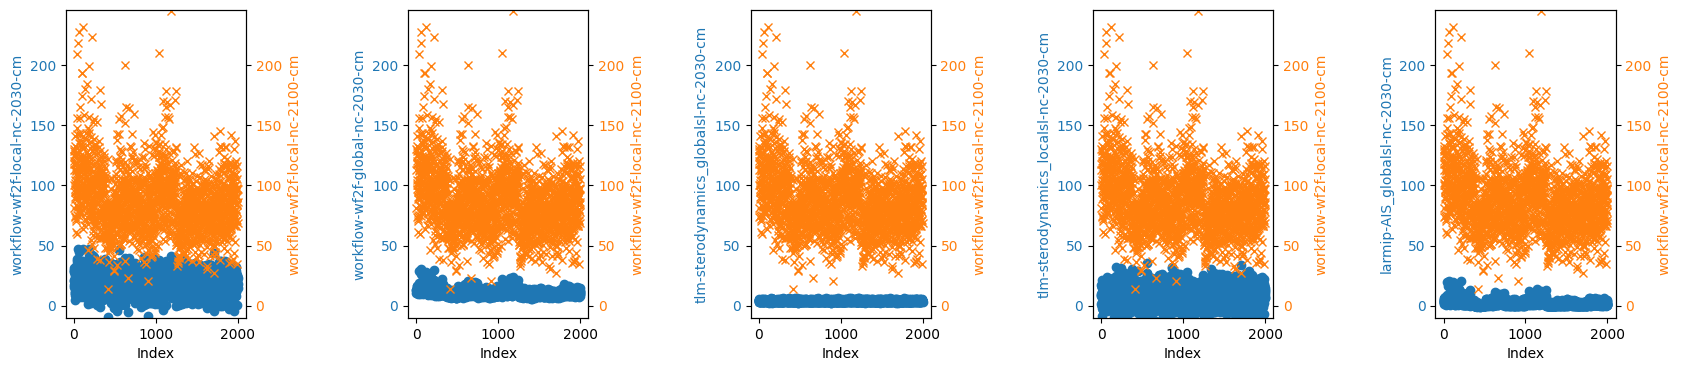

In [3]:
cd.PLOTraw([INdata1a,INdata1b,INdata1c,INdata1d,INdata1e],
           [datNMEa,datNMEb,datNMEc,datNMEd,datNMEe])

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: Scatter
</span>

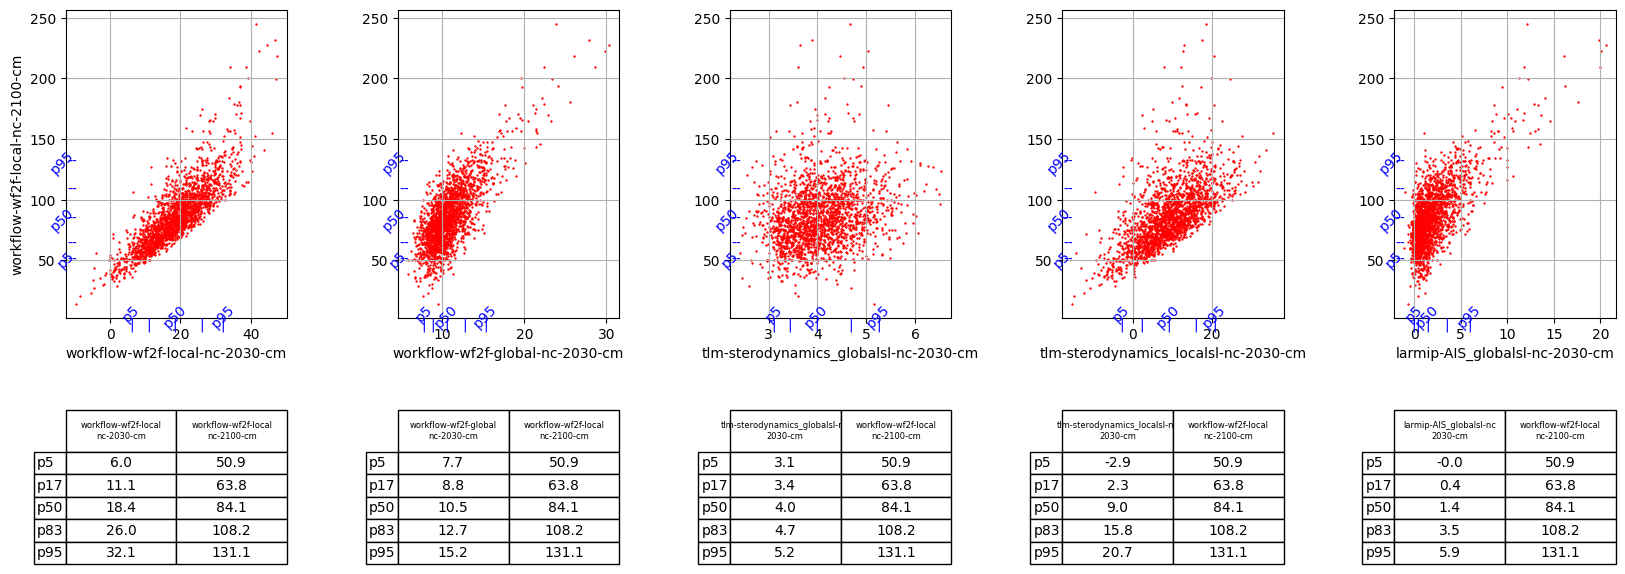

In [4]:
cd.PLOTscatter([INdata1a,INdata1b,INdata1c,INdata1d,INdata1e],
               [datNMEa,datNMEb,datNMEc,datNMEd,datNMEe])

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Compute:: KDE
</span>

In [5]:
normalized_density_values1a, density_values1a, xgrid1a, ygrid1a = cd.COMPkde(INdata1a)
normalized_density_values1b, density_values1b, xgrid1b, ygrid1b = cd.COMPkde(INdata1b)
normalized_density_values1c, density_values1c, xgrid1c, ygrid1c = cd.COMPkde(INdata1c)
normalized_density_values1d, density_values1d, xgrid1d, ygrid1d = cd.COMPkde(INdata1d)
normalized_density_values1e, density_values1e, xgrid1e, ygrid1e = cd.COMPkde(INdata1e)

Optimal bandwidth: 3.35  ||  num_values 109
Optimal bandwidth: 3.62  ||  num_values 109
Optimal bandwidth: 3.88  ||  num_values 114
Optimal bandwidth: 3.71  ||  num_values 118
Optimal bandwidth: 3.96  ||  num_values 118


<br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    PLOT:: KDE
</span>

/Users/pk695/werk.M2/FACTS_dev/2402_BayesianCalWG/facts/JupNbk/000_pk-JupNb_TESTspace/Bayesian_cal_wg/Conditional_Probability/cond_dist.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


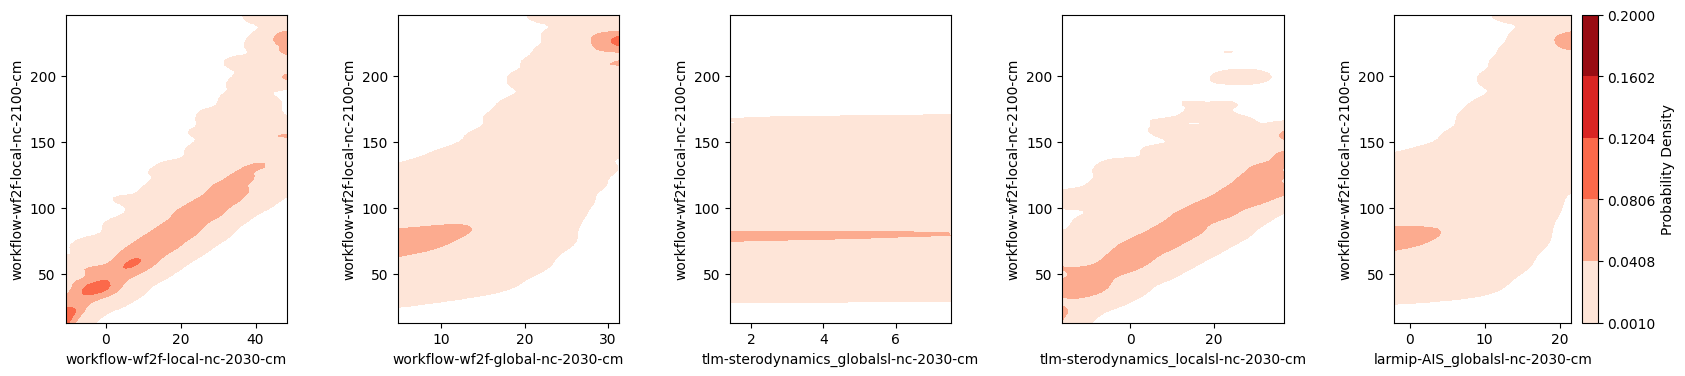

In [6]:
cd.PLOTkde([normalized_density_values1a, normalized_density_values1b, normalized_density_values1c, normalized_density_values1d, normalized_density_values1e], 
           [xgrid1a, xgrid1b, xgrid1c, xgrid1d, xgrid1e], 
           [ygrid1a, ygrid1b, ygrid1c, ygrid1d, ygrid1e],
           [datNMEa,datNMEb,datNMEc,datNMEd,datNMEe])

In [ ]:
column_sums = np.sum(normalized_density_values1c, axis=0)
plt.plot(column_sums,'.',markersize=.25,color='black')
plt.ylim(0.999, 1.001)

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: Conditional Probability 
</span>


In [ ]:
x_values = [(6, 32, 50), (7, 15, 50), (3, 5, 50), (-3, 21, 50), (0, 6, 50)]
# y_limits = [(50, 131), (51, 131), (51, 131), (51, 131), (51, 131)]

cd.PLOTcondProb([normalized_density_values1a, normalized_density_values1b, normalized_density_values1c, normalized_density_values1d, normalized_density_values1e], 
           [xgrid1a, xgrid1b, xgrid1c, xgrid1d, xgrid1e], 
           [ygrid1a, ygrid1b, ygrid1c, ygrid1d, ygrid1e],
           x_values)

In [ ]:
x_values = [(6, 32, 50), (7, 15, 50), (3, 5, 50), (-3, 21, 50), (0, 6, 50)]
y_limits = [(50, 131), (51, 131), (51, 131), (51, 131), (51, 131)]

cd.PLOTcondProb([normalized_density_values1a, normalized_density_values1b, normalized_density_values1c, normalized_density_values1d, normalized_density_values1e], 
           [xgrid1a, xgrid1b, xgrid1c, xgrid1d, xgrid1e], 
           [ygrid1a, ygrid1b, ygrid1c, ygrid1d, ygrid1e],
           x_values, y_limits)

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))

<div style="position: relative; width: 100%;">
    <hr style="position: absolute; left: 0; width: 50%; border: none; height: 2px; background-color: yellow; border-style: dotted;">
</div>
<span style="font-size: 12pt; color: blue; font-family: 'Times New Roman';"> SCRATCH </span>  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of X values to consider
x_values = np.linspace(0, 10, 50)  # 50 points between 0 and 10

# Prepare an array to hold the conditional densities for each X value
conditional_densities = np.zeros((len(ygrid), len(x_values)))

# Loop through each chosen X value
for i, chosen_x in enumerate(x_values):
    # Find the closest index for chosen_x in xgrid
    x_idx = np.abs(xgrid - chosen_x).argmin()
    
    # Extract the joint density values at this X value
    joint_density_at_x = normalized_density_values[:, x_idx]
    
    # Calculate the marginal density for this X value (sum over Y)
    marginal_density_x = np.sum(joint_density_at_x)
    
    # Compute the conditional density P(Y|X)
    conditional_density_y_given_x = joint_density_at_x / marginal_density_x
    
    # Store the conditional density for this X value
    conditional_densities[:, i] = conditional_density_y_given_x

# Create a plot to show the conditional densities
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(x_values, ygrid)
plt.contourf(X, Y, conditional_densities, cmap='Reds', levels=20, alpha=0.8)
plt.colorbar(label='Probability Density')
plt.title('Conditional Distribution P(Y|X) across X values')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0,100)
plt.grid(True)
plt.show()


In [ ]:
column_sums = np.sum(conditional_densities, axis=0)
plt.plot(column_sums,'.',markersize=.25,color='black')
plt.ylim(0.999, 1.001)

In [ ]:
import numpy as np

def ptile(inDATA,percentile,axis):
    percentiles = np.percentile(inDATA, [percentile], axis=axis)
    # Find the row indices that are closest to the 17th percentiles for each column
    row_indices = np.argmin(np.abs(inDATA - percentiles), axis=axis)
    
    # Extract the values corresponding to these indices
    corresponding_values = inDATA[row_indices, np.arange(inDATA.shape[axis])]
    
    # Create a zero matrix with the same shape as inDATA
    result_matrix = np.zeros_like(inDATA)

    if axis == 0:
        # Assign the corresponding values to the result matrix
        result_matrix[row_indices, np.arange(inDATA.shape[1])] = inDATA[row_indices, np.arange(inDATA.shape[1])]
    else:
        # Assign the corresponding values to the result matrix for axis=1
        result_matrix[np.arange(inDATA.shape[0]), row_indices] = inDATA[np.arange(inDATA.shape[0]), row_indices]

    return percentiles, row_indices, result_matrix



In [ ]:
p17, pos17,res17 = ptile(normalized_density_values, 17, 0)
p50, pos50,res50 = ptile(normalized_density_values, 50, 0)
p83, pos83,res83 = ptile(normalized_density_values, 83, 0)
p99, pos99,res99 = ptile(normalized_density_values, 99, 0)

In [ ]:
# xaxis = np.linspace(1, 100, 100)
plt.plot(np.squeeze(pos17),np.squeeze(p17),'o') 
plt.plot(np.squeeze(pos50),np.squeeze(p50),'.') 
plt.plot(np.squeeze(pos83),np.squeeze(p83),'x')
plt.plot(np.squeeze(pos99),np.squeeze(p99),'*') 
# plt.ylim(0.0999, 1.001)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax=axs[0]

clevels=np.linspace(0.001,0.2,6)
clabels=np.round(clevels,decimals=3).astype('str')
contour=ax.contourf(Xgrid, Ygrid, normalized_density_values,levels=clevels,cmap='Blues')
# contour=ax.contourf(Xgrid, Ygrid, res17,levels=clevels,cmap='Reds')
# contour=ax.contourf(Xgrid, Ygrid, res50,levels=clevels,cmap='Reds')
contour=ax.contourf(Xgrid, Ygrid, res83,levels=clevels,cmap='Reds')
# contour=ax.contour(Xgrid, Ygrid, res50,levels=clevels,colors='black')

## Add labels to the contour lines
ax.clabel(contour, inline=True, fontsize=2, fmt='%1.4f')


# remove other subaxis.
for i in [1, 2, 3]: axs[i].set_visible(False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of X values to consider (0, 5, 10)
x_values = np.arange(0, 21, 5)

# Create a plot for the conditional distributions
plt.figure(figsize=(12, 6))

# Loop through each chosen X value
for chosen_x in x_values:
    # Find the closest index for chosen_x in xgrid
    x_idx = np.abs(xgrid1a - chosen_x).argmin()

    # Extract the joint density values at this X value
    joint_density_at_x = normalized_density_values1a[:, x_idx]

    # Calculate the marginal density for this X value (sum over Y)
    marginal_density_x = np.sum(joint_density_at_x)

    # Compute the conditional density P(Y|X)
    conditional_density_y_given_x = joint_density_at_x / marginal_density_x

    # Plot the conditional density with a shaded area
    plt.fill_between(ygrid1a, conditional_density_y_given_x, alpha=0.4, label=f'X={chosen_x}')
    plt.plot(ygrid1a, conditional_density_y_given_x, linewidth=2)

# Add labels and legend
plt.title('Conditional Distribution P(Y|X) for Different X Values')
plt.xlabel('Y')
plt.ylabel('P(Y|X)')
plt.legend(title='X Values')
plt.grid(True)
plt.show()
